In [43]:
# Enable auto-reload of modified python files.
%load_ext autoreload
%autoreload 2

# Imports
from pprint import pprint 
from glob import glob
import sys, copy, os
import shlex, subprocess
sys.path.append('../')

import matplotlib
%matplotlib inline 
import matplotlib.image as mplimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import seaborn as sns

import cv2

import numpy as np
import scipy
import pandas as pd
pd.set_eng_float_format(accuracy=3, use_eng_prefix=True)

from scipy import ndimage

import settings
import cPickle as pck


# Helper functions
def cond_mkdir(path):
    '''Helper function to create a directory if it doesn't exist already.'''
    if not os.path.exists(path):
        os.makedirs(path)

def print_logfile_stats(log): 
    '''Prints the number of runs per viewpoint in this logfile.'''
    print("Total of %d runs."%len(log)) 
    for i in xrange(4): 
        print("Viewpoint %d: %d"%(i, len(log[log['viewpoint_idx']==i]))) 

def load_logfile(path): 
    '''
    Loads a logfile of eyetracking records from dist, given the path to the pickle file.
    '''
    with open(path, 'r') as log_file: 
        log = pck.load(log_file) 
    print("Loaded %s."%path) 
    print_logfile_stats(log) 
    return log 


def gnomonic2lat_lon(x_y_coords, fov_vert_hor, center_lat_lon):
    '''
    Converts gnomonoic (x, y) coordinates to (latitude, longitude) coordinates.
    
    x_y_coords: numpy array of floats of shape (num_coords, 2) 
    fov_vert_hor: tuple of vertical, horizontal field of view in degree
    center_lat_lon: The (lat, lon) coordinates of the center of the viewport that the x_y_coords are referencing.
    '''
    sphere_radius_lon = 1. / (2.0 * np.tan(np.radians(fov_vert_hor[1] / 2.0)))
    sphere_radius_lat = 1. / (2.0 * np.tan(np.radians(fov_vert_hor[0] / 2.0)))

    x, y = x_y_coords[:,0], x_y_coords[:,1]

    x_y_hom = np.column_stack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))])

    K_inv = np.zeros((3, 3))
    K_inv[0, 0] = 1.0/sphere_radius_lon
    K_inv[1, 1] = 1.0/sphere_radius_lat
    K_inv[0, 2] = -1./(2.0*sphere_radius_lon)
    K_inv[1, 2] = -1./(2.0*sphere_radius_lat)
    K_inv[2, 2] = 1.0

    R_lat = np.zeros((3,3))
    R_lat[0,0] = 1.0
    R_lat[1,1] = np.cos(np.radians(-center_lat_lon[0]))
    R_lat[2,2] = R_lat[1,1]
    R_lat[1,2] = -1.0 * np.sin(np.radians(-center_lat_lon[0]))
    R_lat[2,1] = -1.0 * R_lat[1,2]

    R_lon = np.zeros((3,3))
    R_lon[2,2] = 1.0
    R_lon[0,0] = np.cos(np.radians(-center_lat_lon[1]))
    R_lon[1,1] = R_lon[0,0]
    R_lon[0,1] = - np.sin(np.radians(-center_lat_lon[1]))
    R_lon[1,0] = - R_lon[0,1]

    R_full = np.matmul(R_lon, R_lat)

    dot_prod = np.sum(np.matmul(R_full, K_inv).reshape(1,3,3) * x_y_hom.reshape(-1, 1, 3), axis=2)

    sphere_points = dot_prod/np.linalg.norm(dot_prod, axis=1, keepdims=True)

    lat = np.degrees(np.arccos(sphere_points[:, 2]))
    lon = np.degrees(np.arctan2(sphere_points[:, 0], sphere_points[:, 1]))

    lat_lon = np.column_stack([lat, lon])
    lat_lon = np.mod(lat_lon, np.array([180.0, 360.0]))

    return lat_lon

def angle2img(lat_lon_array, img_height_width):
    '''
    Convertes an array of latitude, longitude coordinates to image coordinates with range (0, height) x (0, width)
    '''
    return lat_lon_array / np.array([180., 360.]).reshape(1,2) * np.array(img_height_width).reshape(1,2)

def stitch2video(video_name, frame_dir, fps=30., print_output=False):
    '''
    Uses ffmpeg to stitch together a bunch of frames to a video. frame_dir has to be an absolute path. 
    '''
    framename_format_string = os.path.join(frame_dir, "%06d.png")
    ffmpeg_cmd = "ffmpeg -r %d -f image2 -s 1920x1080 -i %s -vcodec libx264 -crf 25  %s -y"%\
                    (fps, framename_format_string, video_name)
    args = shlex.split(ffmpeg_cmd)
    
    p = subprocess.Popen(args, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, err = p.communicate()
   
    if print_output:
        pprint(output)
        pprint(err)
        
def salmap_from_norm_coords(norm_coords, sigma, height_width):
    '''
    Base function to compute general saliency maps, given the normalized (from 0 to 1)
    fixation coordinates, the sigma of the gaussian blur, and the height and
    width of the saliency map in pixels.
    '''
    img_coords = np.mod(np.round(norm_coords * np.array(height_width)), np.array(height_width)-1.0).astype(int)

    gaze_counts = np.zeros((height_width[0], height_width[1]))
    for coord in img_coords:
        gaze_counts[coord[0], coord[1]] += 1.0

    gaze_counts[0, 0] = 0.0

    sigma_y = sigma
    salmap = ndimage.filters.gaussian_filter1d(gaze_counts, sigma=sigma_y, mode='wrap', axis=0)

    # In x-direction, we scale the radius of the gaussian kernel the closer we get to the pole
    for row in xrange(salmap.shape[0]):
        angle = (row/float(salmap.shape[0]) - 0.5) * np.pi
        sigma_x = sigma_y / (np.cos(angle) + 1e-3)
        salmap[row,:] = ndimage.filters.gaussian_filter1d(salmap[row,:], sigma=sigma_x, mode='wrap')

    salmap /= float(np.sum(salmap))
    return salmap

        
def get_gaze_salmap(list_of_runs, sigma_deg=1.0, height_width=(720, 1440)):
    '''Computes gaze saliency maps.'''
    fixation_coords = []

    for run in list_of_runs:
        relevant_fixations = run['gaze_fixations']

        if len(relevant_fixations.shape) > 1:
            _, unique_idcs = np.unique(relevant_fixations[:, 0], return_index=True)
            all_fixations = relevant_fixations[unique_idcs]
            fixation_coords.append(all_fixations)

    norm_coords = np.vstack(fixation_coords)[:,::-1]

    return salmap_from_norm_coords(norm_coords, sigma_deg * height_width[1]/360.0, height_width)

def get_head_salmap(list_of_runs, height_width=(720, 1440)):
    '''Computes head saliency maps.'''
    thresh=37.196
    all_head_velos = []
    all_head_lat_lons = []

    for run in list_of_runs:
        all_head_velos.append(run['ang_head_velo'])
        all_head_lat_lons.append(run['headLatLon'])

    head_velos = np.vstack(all_head_velos)
    head_lat_lons = np.vstack(all_head_lat_lons)

    fixation_idcs = head_velos[:, 1] < thresh
    fix_lat_lons = head_lat_lons[fixation_idcs]
    norm_fix_coords = fix_lat_lons / np.array([180, 360])

    # Get this cubemap's gaze salmap
    salmap = salmap_from_norm_coords(norm_fix_coords, sigma=19.0, height_width=height_width)

    return salmap

def overlay_image_salmap(img_path, salmap):
    '''Overlays an image with a saliency map.'''
    image = matplotlib.image.imread(img_path).astype(float)[:,:,:3]
    salmap_resized = cv2.resize(salmap, (image.shape[1], image.shape[0])).astype(float)

    fig,ax = plt.subplots(frameon=False)
    fig.set_size_inches(16,8)

    ax.imshow(image)
    ax.imshow(salmap_resized, cmap=plt.cm.jet, alpha=0.4)

    ax.axis('tight')
    ax.axis('off')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

    return fig, ax

def filter_starting_point(list_of_runs, threshold_deg=20.0):
    '''Filters all measurements of a run that are at the 
    beginning and in a vicinity of threshold_deg around the starting coordinates.'''
    cleaned_runs = []
    for run in list_of_runs:
        init_starting_point_lon = run['gaze_lat_lon'][0, 1]
        outside_bool = np.absolute(init_starting_point_lon - run['gaze_lat_lon'][:, 1])>threshold_deg
        if np.any(outside_bool):
            first_left = np.amin(np.where(outside_bool)[0])
            cleaned_runs.append({key:value[first_left:] for key, value in run.iteritems()})
        else:
            cleaned_runs.append(run)
    return cleaned_runs

def get_data_matrix(list_of_runs, column_set='vr'):
    '''Joins specified columns of a list of runs to a single data matrix
    gaze_lat_lon_offset_lon'''
    if column_set=='vr':
        columns=['gaze_lat_lon_offset', 'gaze_fixations_single', 'ang_gaze_offset_velo', 'ang_head_velo', 'ang_gaze_velo', 'headTilt', 'gaze_fixations_ind']
    else:
        columns=['gaze_lat_lon_offset', 'gaze_fixations_single', 'ang_gaze_offset_velo', 'ang_head_velo', 'ang_gaze_velo', 'gaze_fixations_ind']
        
    data = []
    column_names =[]
    for column in columns:
        array_list = []

        for run in list_of_runs:
            array_list.append(np.squeeze(np.array(run[column])))

        if len(array_list[0].shape) == 1:
            joined_array = np.concatenate(array_list)

            data.append(joined_array)
            column_names.append(column)
        else:
            joined_array = np.vstack(array_list)

            data.append(joined_array[:, 0])
            data.append(joined_array[:, 1])
            column_names.append(column + '_lat')
            column_names.append(column + '_lon')

    return np.column_stack(data), column_names

def reject_gauss_outliers(data, column_names, m=2, take_absolute=True):
    '''Function to reject the outliers visible in above plot. Assumes a fundamentally normal distribution,
    which is close to what we see in the data.'''
    if take_absolute:
        data_ = np.absolute(data)
    else:
        data_ = np.copy(data)

    data_ = np.ma.masked_invalid(data_)

    col_means = np.nanmean(data_, axis=0, keepdims=True)
    centered_data = data_ - col_means
    column_stds = np.nanstd(data_, axis=0)

    bad_values_bool = np.absolute(centered_data) > m * column_stds
    bad_values = np.where(bad_values_bool)

    cleaned_data = np.copy(data)
    cleaned_data[bad_values] = np.take(col_means,bad_values[1])

    print("Rejection percentages:")
    for i in xrange(bad_values_bool.shape[1]):
        print("Column %s: %0.4f"%(column_names[i],
                               float(np.sum(bad_values_bool[:, i], axis=0))/bad_values_bool.shape[0]))

    return cleaned_data, col_means, column_stds

def plot_with_viewport(img, viewport_coords, out_path):
    viewport_coords_resh = viewport_coords.reshape(800,800,2)
    upper_line = viewport_coords_resh[0,:,:]
    lower_line = viewport_coords_resh[-1, :,:]
    right_line = viewport_coords_resh[:,-1, :]
    left_line=viewport_coords_resh[:,0,:]

    lines = [upper_line, lower_line, right_line, left_line]

    split_lines = []
    for line in lines:
        diff = np.diff(line, axis=0)
        wrap_idcs = np.where(np.abs(diff)>10)[0]
        if not len(wrap_idcs):
            split_lines.append(line)
        else:
            split_lines.append(line[:wrap_idcs[0]+1])
            split_lines.append(line[wrap_idcs[0]+1:])

    fig, ax = plt.subplots(frameon=False)
    fig.set_size_inches(48,24)
    ax.imshow(img)
 
    for line in split_lines:
        ax.plot(line[:,1], line[:,0], color='black', linewidth=10)
 
    for line in split_lines:
        ax.plot(line[:,1], line[:,0], color='white',linewidth=8)
 
    ax.axis('tight')
    ax.axis('off')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

    fig.savefig(out_path, bbox_inches='tight', pad_inches=0)
    fig.clf()
    plt.close()

def get_gnomonic_hom(center_lat_lon, origin_image, height_width, fov_vert_hor=(60.0, 60.0) ):
    '''Extracts a gnomonic viewport with height_width from origin_image 
    at center_lat_lon with field of view fov_vert_hor.
    '''
    org_height_width, _ = origin_image.shape[:2], origin_image.shape[-1]
    height, width = height_width
    
    if len(origin_image.shape) == 3:
        result_image = np.zeros((height, width, 3))
    else:
        result_image = np.zeros((height, width))        

    sphere_radius_lon = width / (2.0 * np.tan(np.radians(fov_vert_hor[1] / 2.0)))
    sphere_radius_lat = height / (2.0 * np.tan(np.radians(fov_vert_hor[0] / 2.0)))

    y, x = np.mgrid[0:height, 0:width]
    x_y_hom = np.column_stack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))])

    K_inv = np.zeros((3, 3))
    K_inv[0, 0] = 1.0/sphere_radius_lon
    K_inv[1, 1] = 1.0/sphere_radius_lat
    K_inv[0, 2] = -width/(2.0*sphere_radius_lon)
    K_inv[1, 2] = -height/(2.0*sphere_radius_lat)
    K_inv[2, 2] = 1.0

    R_lat = np.zeros((3,3))
    R_lat[0,0] = 1.0
    R_lat[1,1] = np.cos(np.radians(-center_lat_lon[0]))
    R_lat[2,2] = R_lat[1,1]
    R_lat[1,2] = -1.0 * np.sin(np.radians(-center_lat_lon[0]))
    R_lat[2,1] = -1.0 * R_lat[1,2]

    R_lon = np.zeros((3,3))
    R_lon[2,2] = 1.0
    R_lon[0,0] = np.cos(np.radians(-center_lat_lon[1]))
    R_lon[1,1] = R_lon[0,0]
    R_lon[0,1] = - np.sin(np.radians(-center_lat_lon[1]))
    R_lon[1,0] = - R_lon[0,1]

    R_full = np.matmul(R_lon, R_lat)

    dot_prod = np.sum(np.matmul(R_full, K_inv).reshape(1,3,3) * x_y_hom.reshape(-1, 1, 3), axis=2)

    sphere_points = dot_prod/np.linalg.norm(dot_prod, axis=1, keepdims=True)

    lat = np.degrees(np.arccos(sphere_points[:, 2]))
    lon = np.degrees(np.arctan2(sphere_points[:, 0], sphere_points[:, 1]))

    lat_lon = np.column_stack([lat, lon])
    lat_lon = np.mod(lat_lon, np.array([180.0, 360.0]))

    org_img_y_x = lat_lon / np.array([180.0, 360.0]) * np.array(org_height_width)
    org_img_y_x = np.clip(org_img_y_x, 0.0, np.array(org_height_width).reshape(1, 2) - 1.0).astype(int)
    org_img_y_x = org_img_y_x.astype(int)
    
    if len(origin_image.shape) == 3:
        result_image[x_y_hom[:, 1].astype(int), x_y_hom[:, 0].astype(int), :] = origin_image[org_img_y_x[:, 0],
                                                                     org_img_y_x[:, 1], :]  
    else:
        result_image[x_y_hom[:, 1].astype(int), x_y_hom[:, 0].astype(int)] = origin_image[org_img_y_x[:, 0],
                                                                     org_img_y_x[:, 1]] 
    return result_image.astype(float), org_img_y_x

def get_pano_no(pano_no, undersample=3):
    '''Helper function to load the panorama oc scene pano_no and downsample it by a factor of undersample.'''
    path = os.path.join(settings.IMG_PATH, 'cubemap_%04d.png'%pano_no)
    pano = mplimg.imread(path)
    pano = pano[::undersample, ::undersample, :3]
    return pano

def extract_vid_frames(vid_path, target_dir, fps=15, print_output=False):
    '''Extract frames from a video, wrapping ffmpeg.'''
    vid_name = os.path.basename(vid_path)
    vid_name_no_ext = os.path.splitext(vid_name)[0]
    
    ffmpeg_template = 'ffmpeg -i {} -vf fps={} {}'

    ffmpeg_cmd = ffmpeg_template.format(vid_path, fps, os.path.join(target_dir, '%06d.png'))
    args = shlex.split(ffmpeg_cmd)
    
    p = subprocess.Popen(args, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, err = p.communicate()
   
    if print_output:
        pprint(output)
        pprint(err)
        
def interpolate_nan_rows(array, bad_rows_bool):
    '''Interpolates nan rows in an array.'''
    if True not in bad_rows_bool.astype(bool): return array

    good_rows = np.where(np.logical_not(bad_rows_bool))[0]

    # Since extrapolation is a bad idea, we identify the low-confidence indices that are outside the interpolatable range.
    low_non_nan, high_non_nan = np.amin(good_rows), np.amax(good_rows)
    interp_idcs = np.copy(bad_rows_bool)
    interp_idcs[high_non_nan:] = False
    interp_idcs[:low_non_nan] = False

    extra_idcs = np.logical_and(bad_rows_bool,
                             np.logical_or(np.arange(len(bad_rows_bool)) <= low_non_nan,
                                           np.arange(len(bad_rows_bool)) >= high_non_nan))

    interp_func = scipy.interpolate.interp1d(good_rows,
                                    np.take(array, good_rows, axis=0),
                                    kind='linear',
                                    axis=0)
    array[interp_idcs] = interp_func(np.where(interp_idcs)[0])
    # The indices outside the interpolatable range are set to the mean of the series.
    array[extra_idcs] = np.mean(array[good_rows], axis=0)

    return array

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preload files into memory

In [31]:
# Load runs for standing VR condition
all_files = sorted(glob(os.path.join(settings.DATASET_PATH_VR, '*.pck')))
runs_files = [load_logfile(logfile) for logfile in all_files]

# Also assemble all runs into a single list for analyses on all scenes.      
all_runs_list = []
for run in runs_files:
    all_runs_list.extend(run['data'])  
print(len(all_runs_list))

Loaded data/vr/cubemap_0000.pck.
Total of 46 runs.
Viewpoint 0: 9
Viewpoint 1: 17
Viewpoint 2: 10
Viewpoint 3: 10
Loaded data/vr/cubemap_0001.pck.
Total of 31 runs.
Viewpoint 0: 7
Viewpoint 1: 8
Viewpoint 2: 10
Viewpoint 3: 6
Loaded data/vr/cubemap_0002.pck.
Total of 34 runs.
Viewpoint 0: 8
Viewpoint 1: 9
Viewpoint 2: 9
Viewpoint 3: 8
Loaded data/vr/cubemap_0003.pck.
Total of 26 runs.
Viewpoint 0: 8
Viewpoint 1: 5
Viewpoint 2: 5
Viewpoint 3: 8
Loaded data/vr/cubemap_0004.pck.
Total of 28 runs.
Viewpoint 0: 4
Viewpoint 1: 9
Viewpoint 2: 8
Viewpoint 3: 7
Loaded data/vr/cubemap_0005.pck.
Total of 29 runs.
Viewpoint 0: 6
Viewpoint 1: 7
Viewpoint 2: 5
Viewpoint 3: 11
Loaded data/vr/cubemap_0006.pck.
Total of 34 runs.
Viewpoint 0: 10
Viewpoint 1: 7
Viewpoint 2: 8
Viewpoint 3: 9
Loaded data/vr/cubemap_0007.pck.
Total of 32 runs.
Viewpoint 0: 8
Viewpoint 1: 6
Viewpoint 2: 10
Viewpoint 3: 8
Loaded data/vr/cubemap_0008.pck.
Total of 35 runs.
Viewpoint 0: 9
Viewpoint 1: 7
Viewpoint 2: 8
Viewpoint

In [32]:
# Load runs for browser condition
all_files_browser = sorted(glob(os.path.join(settings.DATASET_PATH_BROWSER, '*.pck')))
runs_files_browser = [load_logfile(logfile) for logfile in all_files_browser]
        
# Also assemble all runs into a single list for analyses on all scenes.      
all_runs_list_browser = []
for run in runs_files_browser:
    all_runs_list_browser.extend(run['data'])  
print(len(all_runs_list_browser))

Loaded data/browser/0.pck.
Total of 44 runs.
Viewpoint 0: 10
Viewpoint 1: 12
Viewpoint 2: 12
Viewpoint 3: 10
Loaded data/browser/1.pck.
Total of 42 runs.
Viewpoint 0: 10
Viewpoint 1: 10
Viewpoint 2: 12
Viewpoint 3: 10
Loaded data/browser/10.pck.
Total of 41 runs.
Viewpoint 0: 10
Viewpoint 1: 11
Viewpoint 2: 11
Viewpoint 3: 9
Loaded data/browser/11.pck.
Total of 39 runs.
Viewpoint 0: 10
Viewpoint 1: 10
Viewpoint 2: 9
Viewpoint 3: 10
Loaded data/browser/12.pck.
Total of 40 runs.
Viewpoint 0: 11
Viewpoint 1: 11
Viewpoint 2: 9
Viewpoint 3: 9
Loaded data/browser/13.pck.
Total of 40 runs.
Viewpoint 0: 11
Viewpoint 1: 10
Viewpoint 2: 10
Viewpoint 3: 9
Loaded data/browser/14.pck.
Total of 41 runs.
Viewpoint 0: 11
Viewpoint 1: 11
Viewpoint 2: 10
Viewpoint 3: 9
Loaded data/browser/15.pck.
Total of 41 runs.
Viewpoint 0: 11
Viewpoint 1: 11
Viewpoint 2: 10
Viewpoint 3: 9
Loaded data/browser/16.pck.
Total of 42 runs.
Viewpoint 0: 12
Viewpoint 1: 11
Viewpoint 2: 10
Viewpoint 3: 9
Loaded data/browser/

# Animate runs in scene 0

In [22]:
def plot_fov(center_lat_lon, ax, color, fov_vert_hor, height_width):
    '''
    Plots the correctly warped FOV at a given center_lat_lon.
    center_lat_lon: Float tuple of latitude, longitude. Position where FOV is centered
    ax: The matplotlib axis object that should used for plotting.
    color: Color of the FOV box.
    height_width: Height and width of the image.
    '''
    # Coordinates for a rectangle.
    coords = []
    coords.append([np.linspace(0.0, 1.0, 100), [1.]*100])
    coords.append([[1.]*100, np.linspace(0.0, 1.0, 100)])
    coords.append([np.linspace(0.0, 1.0, 100), [0.]*100])
    coords.append([[0.]*100, np.linspace(0.0, 1.0, 100)])    

    lines = []
    for coord in coords:
        lat_lon_array = gnomonic2lat_lon(np.column_stack(coord), fov_vert_hor=fov_vert_hor, 
                                         center_lat_lon=center_lat_lon)
        img_coord_array = angle2img(lat_lon_array, height_width)
        lines.append(img_coord_array)
        
    split_lines = []
    for line in lines:
        diff = np.diff(line, axis=0)
        wrap_idcs = np.where(np.abs(diff)>np.amin(height_width))[0]
        
        if not len(wrap_idcs):
            split_lines.append(line)
        else:
            split_lines.append(line[:wrap_idcs[0]+1])
            split_lines.append(line[wrap_idcs[0]+1:])

    for line in split_lines:
        ax.plot(line[:,1], line[:,0], color=color, linewidth=1.2, alpha=0.5)

In [23]:
def render_exploration_frames(scene_df, 
                              img_path,
                              target_dir='frames',
                              duration=30.,
                              fps=30.):
    '''
    Renders single frames of a video that visualizes scanpaths and FOV of users in the VR scene img_path.
    Frames can subsequently be stitched together with ffmpeg.
    
    scene_df: pandas Dataframe with all the runs for a specific scene.
    img_path: Path to the equirectangular scene file.
    duration: Duration of the animation in seconds.
    fps: Target fps.
    '''
    num_frames = fps * duration
    img_height, img_width = 2048, 4096
    image = cv2.resize(cv2.imread(img_path), (img_width, img_height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    frame_no = 0
        
    for t in np.linspace(0., duration, num_frames):
        plt.close('all')

        fig, ax = plt.subplots(frameon=False, figsize=(16,9))
        
        ax.grid(b=False)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)

        ax.imshow(image)
        ax.axis('tight')
        ax.set_xlim([0,img_width])
        ax.set_ylim([img_height, 0])
        
        time_template = 'time %.1fs'
        time_text = ax.text(0.05, 0.9, '', size='large', transform=ax.transAxes)
        time_text.set_text(time_template % t)

        fov_vert = 106.188
        aspect_ratio = 0.82034051
        fov_hor = fov_vert * aspect_ratio
        fov_vert_hor = np.array([fov_vert, fov_hor])

        colors = cm.rainbow(np.linspace(0, 1, len(scene_df)))
                
        for color, log_df in zip(colors, scene_df['data']):
            time_filtered = np.where(log_df['timestamp']<=t)[0]
            if len(time_filtered):
                frame_idx = np.amax(time_filtered)
                
                if frame_idx >= len(log_df['timestamp']): 
                    continue
            else:
                continue
            gaze_coords = angle2img(log_df['gaze_lat_lon'][frame_idx, :], (img_height, img_width))
            head_lat_lon = log_df['headLatLon'][frame_idx, :]
            ax.plot(gaze_coords[1], gaze_coords[0], marker='o', markersize=12., color=color, alpha=.8)
            
            plot_fov(head_lat_lon, ax, color, fov_vert_hor, height_width=np.array([img_height, img_width]))
        
        fig.savefig(os.path.join(target_dir, "%06d.png"%frame_no), bbox_inches='tight', pad_inches=0, dpi=160)
        frame_no += 1
        fig.clf()

In [25]:
animation = render_exploration_frames(runs_files[0], os.path.join(settings.IMG_PATH, 'cubemap_0000.png'), fps=24)

In [26]:
# Stitch to video with ffmpeg
stitch2video('scene_0.mp4', fps=24, frame_dir='frames')

## Compute the ground truth saliency map

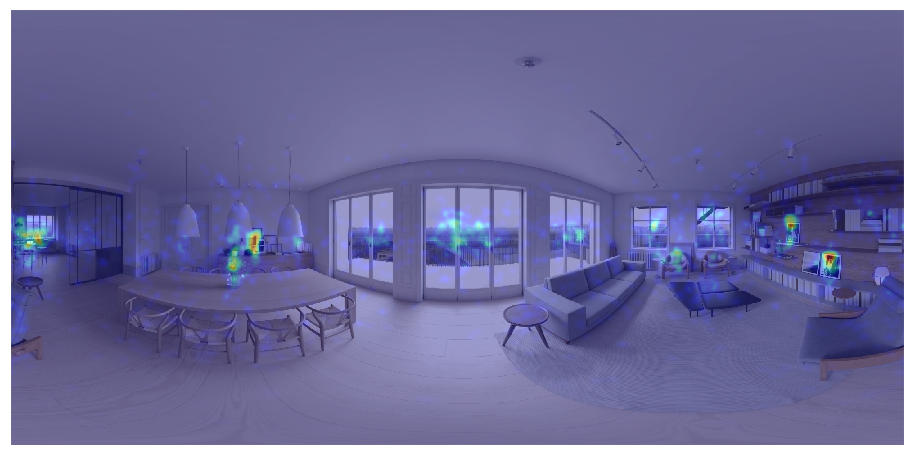

In [27]:
gaze_salmap = get_gaze_salmap(runs_files[0]['data'])
fig, ax = overlay_image_salmap('base_image.png', gaze_salmap)

## Get the head-position only approximation of the ground-truth saliency map

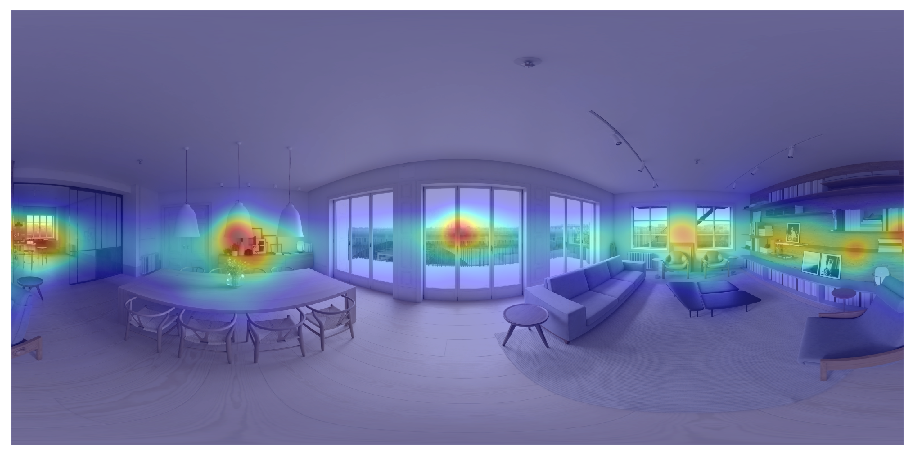

In [28]:
head_salmap = get_head_salmap(runs_files[0]['data'])
fig, ax = overlay_image_salmap('base_image.png', head_salmap)

## Compute the horizon bias baseline

In [29]:
def get_horizon_bias(list_of_runs):
    # We first filter out the fixations in the first few seconds around the starting point.
    # Filter the starting points
    filtered_list = filter_starting_point(list_of_runs)
    horizon_bias_salmap = get_gaze_salmap(filtered_list)

    # We now fit a laplacian to the data, where the longitudinal component is marginalized out.
    all_fix_lats = np.vstack([run['gaze_fixations_single'][run['gaze_fixations_single'][:,1]!=0] for run in filtered_list])[:, 1]*180.0

    param = scipy.stats.laplace.fit(all_fix_lats)

    fig = plt.figure(figsize=(24.0, 9.0))
    gs = matplotlib.gridspec.GridSpec(1,4)
    gs.update(wspace=0.05)

    ax1 = fig.add_subplot(gs[0, 1:4])
    ax2 = fig.add_subplot(gs[0, 0], sharey=ax1)

    ax1.imshow(horizon_bias_salmap, cmap=plt.cm.jet, extent=[0, 360, 0, 180])
    ax1.axis('off')

    ax2.hist(all_fix_lats, bins=90, normed=True, alpha=0.6, color='g', orientation='horizontal')

    ymin, ymax = ax2.get_ylim()
    y = np.arange(180)
    p = scipy.stats.laplace.pdf(y, *param[:-2], loc=param[-2], scale=param[-1])

    ax2.plot(p, y, 'k', linewidth=2)
    ax2.set_ylim([180, 0])
    ax2.axis('off')
    ax2.invert_xaxis()
    
    return param

(91.391403326594329, 17.914838576777939)


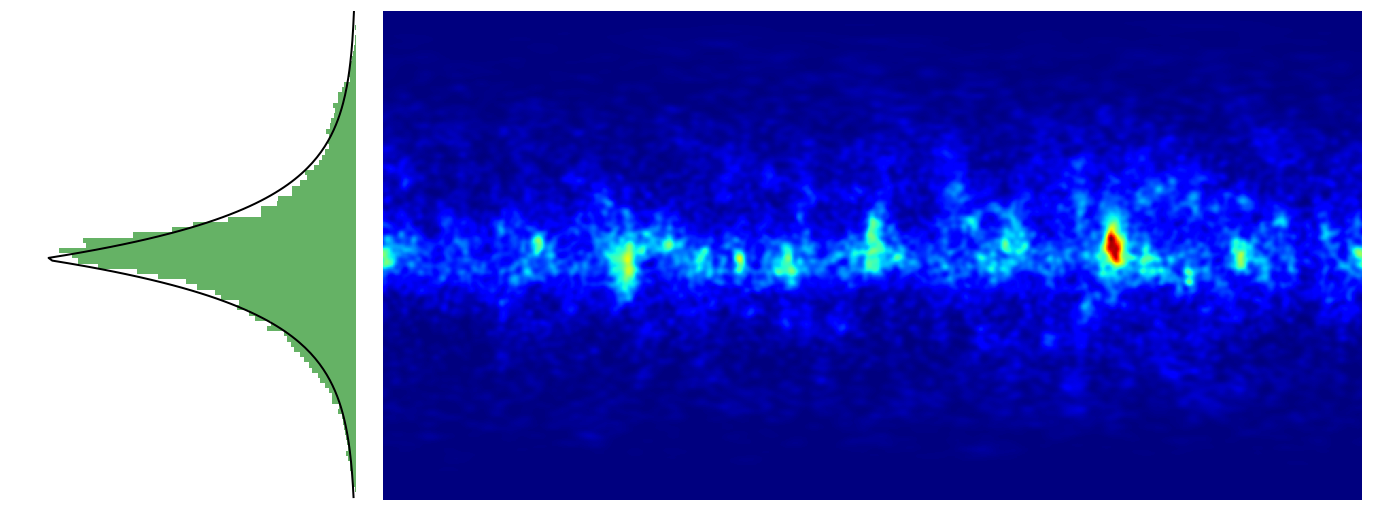

(91.222571982772763, 15.146517401350195)


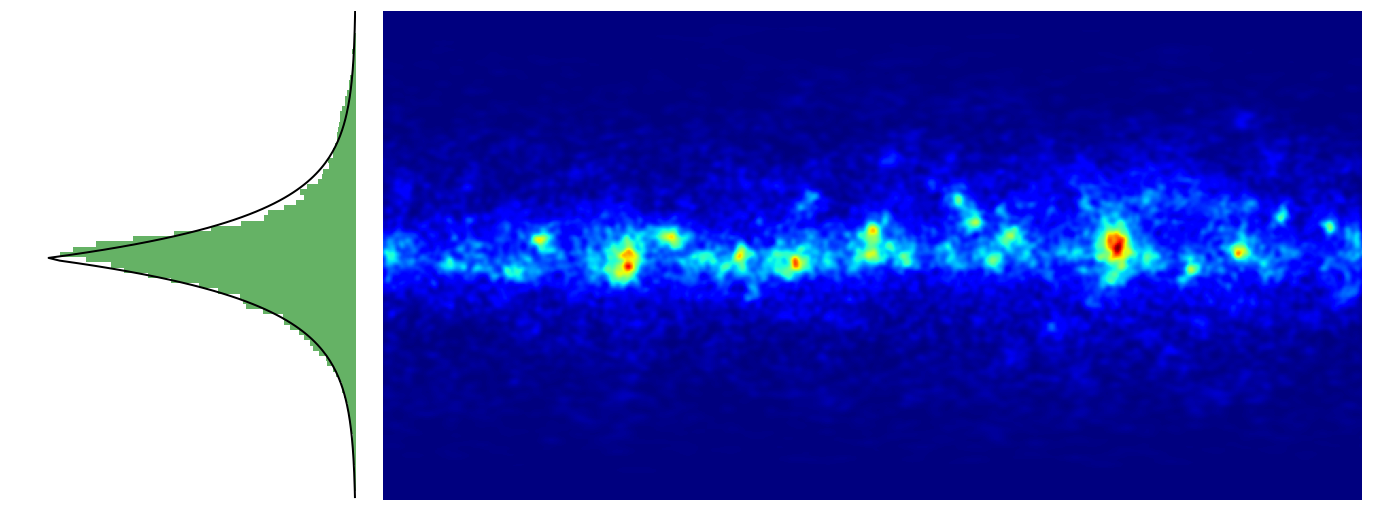

In [33]:
print(get_horizon_bias(all_runs_list))
plt.show()
print(get_horizon_bias(all_runs_list_browser))
plt.show()

## Gaze and head movement analysis

In [34]:
def get_full_df(list_of_runs, mode='vr'):
    # Build a matrix of *all* measurements
    data_matrix, pred_columns = get_data_matrix(list_of_runs, column_set=mode)
    df = pd.DataFrame(data_matrix, columns=pred_columns)

    # Reject measurements that are more than 10 standard deviations away from the mean.
    data_matrix_clean, means, stds = reject_gauss_outliers(data_matrix, pred_columns, m=10)
    df = pd.DataFrame(data_matrix_clean, columns=pred_columns)
    return df

def get_fix_no_fix_data(full_df):
    fix_df = full_df[full_df['gaze_fixations_ind']!=0]
    no_fix_df = full_df[full_df['gaze_fixations_ind']==0]
    fix_data = fix_df[['ang_head_velo_lon','ang_gaze_offset_velo_lon']].values
    no_fix_data = no_fix_df[['ang_head_velo_lon','ang_gaze_offset_velo_lon']].values
    return fix_df, no_fix_df, fix_data, no_fix_data

vr_df = get_full_df(all_runs_list)
fix_df, no_fix_df, fix_data, no_fix_data = get_fix_no_fix_data(vr_df)
browser_df = get_full_df(all_runs_list_browser, mode='browser')

Rejection percentages:
Column gaze_lat_lon_offset_lat: 0.0000
Column gaze_lat_lon_offset_lon: 0.0000
Column gaze_fixations_single_lat: 0.0040
Column gaze_fixations_single_lon: 0.0018
Column ang_gaze_offset_velo_lat: 0.0023
Column ang_gaze_offset_velo_lon: 0.0021
Column ang_head_velo_lat: 0.0003
Column ang_head_velo_lon: 0.0000
Column ang_gaze_velo_lat: 0.0022
Column ang_gaze_velo_lon: 0.0007
Column headTilt: 0.0002
Column gaze_fixations_ind: 0.0000


/home/vincent/anaconda2/envs/vr/lib/python2.7/site-packages/ipykernel_launcher.py:247: RuntimeWarning: invalid value encountered in greater


Rejection percentages:
Column gaze_lat_lon_offset_lat: 0.0000
Column gaze_lat_lon_offset_lon: 0.0000
Column gaze_fixations_single_lat: 0.0040
Column gaze_fixations_single_lon: 0.0056
Column ang_gaze_offset_velo_lat: 0.0003
Column ang_gaze_offset_velo_lon: 0.0002
Column ang_head_velo_lat: 0.0002
Column ang_head_velo_lon: 0.0002
Column ang_gaze_velo_lat: 0.0002
Column ang_gaze_velo_lon: 0.0001
Column gaze_fixations_ind: 0.0000


## Fixation statistics

In [35]:
def get_fixation_stats(list_of_runs):
    fix_durs = []
    fix_counts = []
    for run in list_of_runs:
        fix_counts.append(len(run['gaze_fixations_raw']))
        for fixation in run['gaze_fixations_raw']:
            fix_durs.append(fixation['duration'])
            
    print(np.mean(fix_durs), np.std(fix_durs))
    print(np.mean(fix_counts), np.std(fix_counts))

    return fix_durs, fix_counts

print("VR")
_ = get_fixation_stats(all_runs_list)
print(np.mean(np.abs(vr_df['gaze_lat_lon_offset_lon'])))
print(np.std(np.abs(vr_df['gaze_lat_lon_offset_lon'])))
print('')

print("Browser")
_ = get_fixation_stats(all_runs_list_browser)
print(np.mean(np.abs(browser_df['gaze_lat_lon_offset_lon'])))
print(np.std(np.abs(browser_df['gaze_lat_lon_offset_lon'])))

VR
(0.26618808063154242, 0.13249953006467741)
(55.358974358974358, 12.850695241068856)
12.0355654209
10.7150299275

Browser
(0.25346992106883304, 0.12421519976135226)
(49.682981090100114, 15.040495933334972)
19.8285655257
14.8185745803


### Vestibolu-Ocular reflex

(-400, 400)

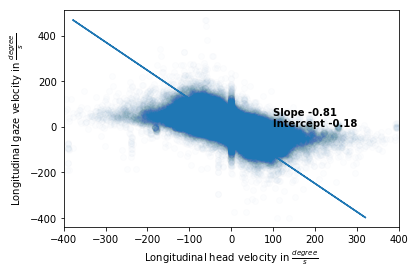

In [36]:
# Formatting
font = {'family': 'sans',
        'weight': 'bold',
        'size': 10,
        }
hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}

# Fit a line to the fixation data - we should see the vestibulo-ocular reflex!
slope, intercept, r, p, _ = scipy.stats.linregress(fix_data[:, 0], fix_data[:, 1])

fig, ax = plt.subplots(1, 1)
ax.scatter(fix_data[:, 1], fix_data[:, 0], alpha = 0.01, facecolor=None)
ax.plot(fix_data[:, 0]*slope + intercept, fix_data[:, 0])
ax.text(100, 0.007, "Slope %0.2f\nIntercept %0.2f"%(slope, intercept), fontdict=font, horizontalalignment='left')

ax.set_xlabel(r'Longitudinal head velocity in $\frac{degree}{s}$')
ax.set_ylabel(r'Longitudinal gaze velocity in $\frac{degree}{s}$')

ax.set_xlim([-400,400])

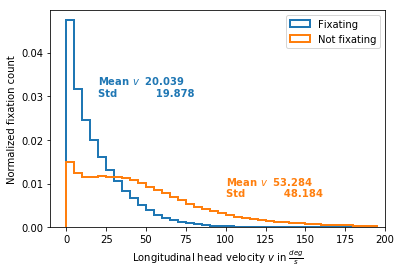

In [37]:
fix_velos = np.absolute(fix_df['ang_head_velo_lon'])
no_fix_velos = np.absolute(no_fix_df['ang_head_velo_lon'])

bins = np.arange(0, 200, 5)
ax = sns.distplot(fix_velos, kde=False, 
                  norm_hist=True, hist_kws=hist_kws, bins=bins, label='Fixating')
sns.distplot(no_fix_velos, 
                  kde=False, norm_hist=True, ax=ax, hist_kws=hist_kws, bins=bins, label='Not fixating')

ax.set_xlabel(r"Longitudinal head velocity $v$ in $\frac{deg}{s}$")
ax.set_ylabel(r"Normalized fixation count")
ax.set_xlim([-10, 200])

ax.legend()

font = {'family': 'sans',
        'color':  'black',
        'weight': 'bold',
        'size': 10,
        }

not_fixating = copy.deepcopy(font)
not_fixating.update({'color':sns.color_palette()[1]})

fixating = copy.deepcopy(font)
fixating.update({'color':sns.color_palette()[0]})

ax.text(20, 0.03, 
        "Mean $v$  %.3f\nStd           %.3f"%(np.mean(fix_velos), np.std(fix_velos)),
                                                fontdict=fixating, horizontalalignment='left')
ax.text(100, 0.007, 
        "Mean $v$  %.3f\nStd           %.3f"%(np.mean(no_fix_velos), np.std(no_fix_velos)),\
        fontdict=not_fixating, horizontalalignment='left')
ax.get_figure().savefig('head_velo_fix_distrib.pdf', bbox_inches='tight')

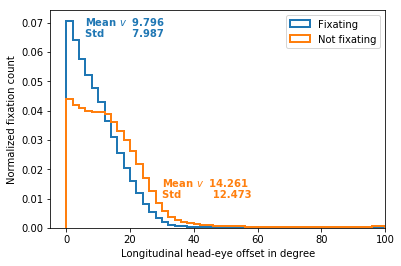

In [38]:
fix_offs = np.absolute(fix_df['gaze_lat_lon_offset_lon'])
no_fix_offs = np.absolute(no_fix_df['gaze_lat_lon_offset_lon'])

bins = np.arange(0, 200, 2)
ax = sns.distplot(fix_offs, bins=bins, kde=False, 
                  norm_hist=True, hist_kws=hist_kws, label='Fixating')
sns.distplot(no_fix_offs, bins=bins, 
                  kde=False, norm_hist=True, ax=ax, hist_kws=hist_kws, label='Not fixating')

ax.set_xlabel(r"Longitudinal head-eye offset in degree")
ax.set_ylabel(r"Normalized fixation count")

ax.legend()
ax.set_xlim([-5, 100])

font = {'family': 'sans',
        'color':  'black',
        'weight': 'bold',
        'size': 10,
        }

not_fixating = copy.deepcopy(font)
not_fixating.update({'color':sns.color_palette()[1]})

fixating = copy.deepcopy(font)
fixating.update({'color':sns.color_palette()[0]})

ax.text(6, 0.065, 
        "Mean $v$  %.3f\nStd        %.3f"%(np.mean(fix_offs), np.std(fix_offs)),
         fontdict=fixating, horizontalalignment='left')
ax.text(30, 0.01, 
        "Mean $v$  %.3f\nStd         %.3f"%(np.mean(no_fix_offs), np.std(no_fix_offs)),
         fontdict=not_fixating, horizontalalignment='left')
ax.get_figure().savefig('gaze_off_distrib.pdf', bbox_inches='tight')

## Exploration time

In [39]:
def get_exploration_times(all_runs):
    angles = np.arange(-360.0, 361.0)
    all_times = -1 * np.ones((len(angles), len(all_runs)))

    for run_idx, run in enumerate(all_runs):
        if run_idx % 100 == 0: print run_idx

        timestamps = np.squeeze(run['timestamp'])
        gaze_velos = np.squeeze(run['ang_gaze_velo'][:-1, 1])

        run_offsets = gaze_velos.reshape(-1,1) * np.diff(timestamps).reshape(-1, 1)
        
        # This filters out eyetracking measurement errors.
        bad_rows = np.squeeze(np.abs(run_offsets)>100)
        run_offsets = interpolate_nan_rows(run_offsets, bad_rows)

        offset_integral = np.zeros(len(run_offsets)+1)
        offset_integral[1:] = np.squeeze(np.cumsum(run_offsets, axis=0))

        for angle_idx, angle in enumerate(angles):
            if angle < 0:
                candidate_idcs = np.logical_and(angle > offset_integral, angle <= np.roll(offset_integral, 5, axis=0))
                if not np.any(candidate_idcs): 
                    continue

                min_idx = np.amin(np.where(candidate_idcs)[0])
                discovery_time = run['timestamp'][min_idx]
            else:
                candidate_idcs = np.logical_and(angle <= offset_integral, angle > np.roll(offset_integral, 5, axis=0))
                if not np.any(candidate_idcs):
                    continue

                min_idx = np.amin(np.where(candidate_idcs)[0])
                discovery_time = run['timestamp'][min_idx]

            all_times[angle_idx, run_idx] = discovery_time

    bad_idcs = all_times < 0
    all_times[bad_idcs] = np.NaN

    return all_times

def get_exploration_statistics(all_times):
    expl_times_avg = np.nanmean(all_times, axis=1)
    expl_times_std = np.nanstd(all_times, axis=1)
    expl_times_min = np.nanpercentile(all_times, q=10, axis=1 )
    expl_times_max = np.nanpercentile(all_times, q=90, axis=1 )

    # For linear regression: mirror the negative angles to fit a single line to both sides
    angles = np.arange(-360.0, 361.0)
    angles_linreg = np.copy(angles)
    angles_linreg[angles_linreg<0] *= -1

    # Fit linear regression to positive angles
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(angles_linreg,expl_times_avg)
    
    return slope, intercept, (expl_times_avg, expl_times_min, expl_times_max)

In [40]:
all_times_vr = get_exploration_times(all_runs_list)

0
100
200
300
400
500
600
700


In [41]:
slope_vr, intercept_vr, expl_time_stats_vr = get_exploration_statistics(all_times_vr)

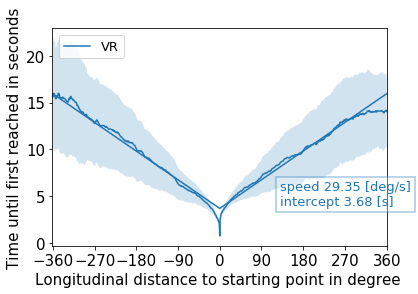

In [42]:
fig, ax = plt.subplots(1)

angles = np.arange(-360.0, 361.0)

ax.plot(angles, expl_time_stats_vr[0], color=sns.color_palette()[0])
# ax.plot(angles, expl_time_stats_bw[0], color=sns.color_palette()[1])

# ax.plot(angles, expl_times_min, angles, expl_times_max, color='lightblue', alpha=0.4)

ax.plot(angles, np.abs(angles*slope_vr) + intercept_vr, c=sns.color_palette()[0], label='VR')
# ax.plot(angles, np.abs(angles*slope_bw) + intercept_bw, c=sns.color_palette()[1], label='Browser')

font = {'family': 'sans',
        'weight': 'normal',
        'size': 13,
        }

vr_font = copy.deepcopy(font)
vr_font.update({'color':sns.color_palette()[0]})

# bw_font = copy.deepcopy(font)
# bw_font.update({'color':sns.color_palette()[1]})

props = dict(boxstyle='square', fc='white', lw=2, alpha=0.3)
props_vr = copy.copy(props)
# props_bw = copy.copy(props)
props_vr.update({'ec':sns.color_palette()[0]})
# props_bw.update({'ec':sns.color_palette()[1]})

ax.text(130, 4, "speed %0.2f [deg/s]\nintercept %0.2f [s]"%(1/slope_vr, intercept_vr), 
        fontdict=vr_font, horizontalalignment='left', bbox=props_vr)
# ax.text(130, 19, "speed %0.2f [deg/s]\nintercept %0.2f [s]"%(1/slope_bw, intercept_bw), 
#         fontdict=bw_font, horizontalalignment='left', bbox=props_bw)

std_region_vr = (expl_time_stats_vr[0] - expl_time_stats_vr[1], expl_time_stats_vr[0] + expl_time_stats_vr[1])
# std_region_bw = (expl_time_stats_bw[0] - expl_time_stats_bw[1], expl_time_stats_bw[0] + expl_time_stats_bw[1])

ax.fill_between(angles, std_region_vr[0], std_region_vr[1], facecolor=sns.color_palette()[0], alpha=0.2)
# ax.fill_between(angles, std_region_bw[0], std_region_bw[1], facecolor=sns.color_palette()[1], alpha=0.2)

ax.set_xlim([-361, 361])
ax.set_xlabel('Longitudinal distance to starting point in degree ', fontsize=15)
ax.set_ylabel('Time until first reached in seconds', fontsize=15)
ax.tick_params(axis='both', labelsize=15)

ax.legend(frameon=True, fontsize=13, loc=2)

_ = ax.set_xticks(np.linspace(-360, 360, num=9))

fig.savefig('exploration_time.pdf', bbox_inches='tight')
